# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on June 10, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 0. Update on the parameter boundary  for model, End phase and Growth phase analysis
### 1. The logistic model was applied to 125 countries
### 2. Mean turning point for these countries is on 2020-05-06
(This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-08-01
(This is also an understimate. If you check the graphs in the bottom, you will find that the numbers in some countires did not decrease as models predict )
### 4. The situation is stablized in most countries. However, some countires in Europe and Africa continue to grow in numbers
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps
import folium; # for world map

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,765,844,851,852,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,86,88,91,92,96,113


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,991,991,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,593,593,594,594,594,594,594,594,594,594
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,358,358,358,358,358,359,359,359,359,360
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,139,139,139,139,139,139,139,139,139,139


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters
    c > 0 (update on April 21, because if c<0, the top horizontal asymptote is b)

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The top horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-1.*c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  1,  0],
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

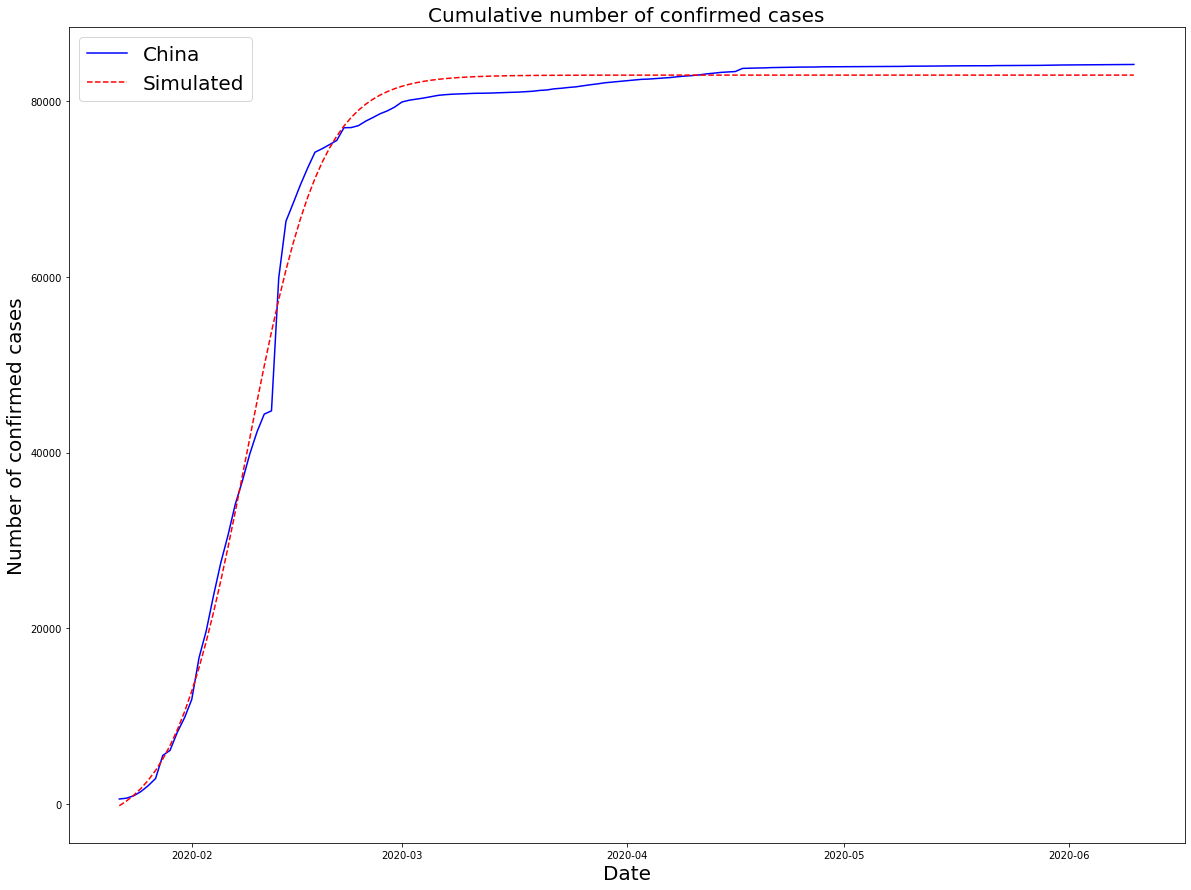

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.994919565840421


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 23:18:39.312403200


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-14 23:30:09.778694400
The total number of confirmed cases is  82998.09210580649


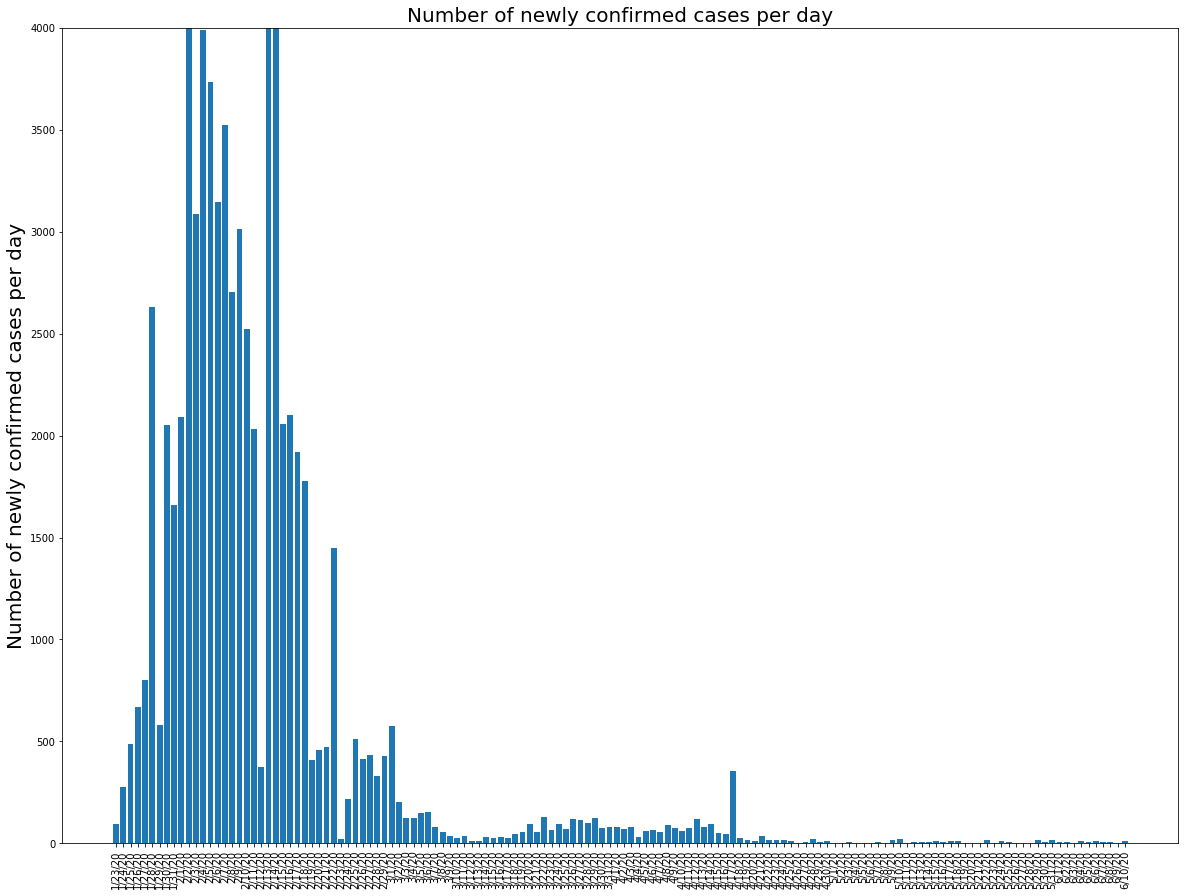

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];
EndP = [];
GP = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]], 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # End phase analysis
    if df1[-1] > 0.95* (popt[0]+popt[1]):
        EndP.append(countries[ct]);
        
    # growth phase analysis
    if df1[-1] - df1[-8] > 2*(df1[-9] - df1[-16]):
        GP.append(countries[ct]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Afghanistan
R^2 =  0.9998383457219565
The day reaches the turning point is on:  2020-06-05 08:46:22.473695999
The day reaches the top of the curve is on:  2020-09-02 06:14:06.254131200
The total number of confirmed cases is  37984.60483084288
Albania
R^2 =  0.9905047407404952
The day reaches the turning point is on:  2020-04-24 03:07:20.741865600
The day reaches the top of the curve is on:  2020-08-26 01:06:04.650796800
The total number of confirmed cases is  1269.5942415052039
Algeria
R^2 =  0.9985789394360828
The day reaches the turning point is on:  2020-05-12 05:05:25.031846400
The day reaches the top of the curve is on:  2020-09-06 07:17:54.182803200
The total number of confirmed cases is  12393.792300932666
Andorra
R^2 =  0.9948128856071513
The day reaches the turning point is on:  2020-04-01 07:36:51.588777600
The day reaches the top of the curve is on:  2020-05-17 06:14:39.296860800
The total number of confirmed cases is  773.9533441513883
Armenia
R^2 =  0.9986737883915403
The 

Equatorial Guinea
R^2 =  0.9905149226168836
The day reaches the turning point is on:  2020-05-18 12:48:22.942195200
The day reaches the top of the curve is on:  2020-07-31 16:11:22.246742400
The total number of confirmed cases is  1571.9298831787544
Estonia
R^2 =  0.9966719271858369
The day reaches the turning point is on:  2020-04-03 09:31:53.479459200
The day reaches the top of the curve is on:  2020-06-05 11:50:56.956387200
The total number of confirmed cases is  1821.8093680374957
Ethiopia
R^2 =  0.9954771903585286
The day reaches the turning point is on:  2020-07-05 15:26:14.047814400
The day reaches the top of the curve is on:  2020-09-21 15:18:26.331955200
The total number of confirmed cases is  27281.71645494889
Finland
R^2 =  0.9984981990824922
The day reaches the turning point is on:  2020-04-17 11:45:10.147824
The day reaches the top of the curve is on:  2020-07-16 10:56:56.305104
The total number of confirmed cases is  7019.238022505024
France
R^2 =  0.9975859459580942
The 

Mexico
R^2 =  0.9994928539127805
The day reaches the turning point is on:  2020-06-04 11:03:00.706694400
The day reaches the top of the curve is on:  2020-09-17 14:57:25.326633599
The total number of confirmed cases is  215195.7068695151
Moldova
R^2 =  0.9944492162710996
The day reaches the turning point is on:  2020-05-17 17:31:55.786483200
The day reaches the top of the curve is on:  2020-09-27 00:06:41.969692800
The total number of confirmed cases is  12608.431473949375
Morocco
R^2 =  0.9986678077582467
The day reaches the turning point is on:  2020-04-28 02:03:35.119987200
The day reaches the top of the curve is on:  2020-07-20 19:00:41.031734400
The total number of confirmed cases is  8380.0868259939
Nepal
R^2 =  0.998544101119532
The day reaches the turning point is on:  2020-06-10 13:13:40.413907200
The day reaches the top of the curve is on:  2020-07-27 14:15:28.492128
The total number of confirmed cases is  9241.501633499067
Netherlands
R^2 =  0.9981572095693984
The day reache

Tanzania
R^2 =  0.9946170715699384
The day reaches the turning point is on:  2020-04-22 05:53:44.225059200
The day reaches the top of the curve is on:  2020-05-24 21:00:47.992867200
The total number of confirmed cases is  512.2281850107414
Thailand
R^2 =  0.9978925846675729
The day reaches the turning point is on:  2020-03-30 16:06:55.833033599
The day reaches the top of the curve is on:  2020-05-13 14:07:04.507795200
The total number of confirmed cases is  3013.949396352942
Togo
R^2 =  0.9884215238196148
The day reaches the turning point is on:  2020-05-22 13:24:49.141353600
The day reaches the top of the curve is on:  2020-09-03 21:49:35.785084800
The total number of confirmed cases is  684.4641836252443
Tunisia
R^2 =  0.9969929098474041
The day reaches the turning point is on:  2020-04-05 13:28:40.360972800
The day reaches the top of the curve is on:  2020-05-29 18:00:08.298374400
The total number of confirmed cases is  1052.5020723695393
Turkey
R^2 =  0.996073770755426
The day reac

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  125


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
115,US,0.995093,2020-04-28 11:13:47.791027200,2020-08-11 19:30:30.601324800,2.00167e+06
13,Brazil,0.999731,2020-06-10 04:49:36.870124800,2020-09-18 03:50:03.007132800,1.5501e+06
99,South Africa,0.99964,2020-08-02 04:06:38.843424,2020-12-03 12:10:28.358342400,1.1598e+06
52,India,0.99959,2020-06-10 23:32:11.753548800,2020-09-25 16:58:47.432524800,582620
89,Russia,0.998549,2020-05-15 14:10:04.768694400,2020-08-03 19:36:13.972809600,524819
80,Pakistan,0.997819,2020-07-03 12:12:10.603584,2020-11-19 02:03:37.571760,484817
34,Egypt,0.999318,2020-07-23 18:44:54.527424,2020-12-10 05:05:10.723574400,379616
19,Chile,0.999009,2020-06-12 09:25:32.279289600,2020-09-21 09:44:04.204867200,327005
83,Peru,0.998709,2020-05-28 16:14:29.265331200,2020-09-05 14:13:38.520393600,297595
113,United Kingdom,0.997848,2020-04-24 17:40:26.470012800,2020-07-21 01:29:05.458444800,290242


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-05-06 13:45:52.743406592
Mean CurveTop for these countries is  2020-08-01 14:06:34.018907904


## End phase of the pandemic

I use the 95% of the CurveTop (i.e. the theoretical maximum) as an indictor for the end phase of the model. Any country will be considered as actually reached the end phase if the total confirmed cases reached this value AND if the number of confirmed cases did not increase from past 14 days to past 7 days. These countries are listed below:

In [19]:
# Create a world map with countries in end phase
# create empty map
world_map = folium.Map(tiles="cartodbpositron");

#for each coordinate, create circlemarker of user percent
for i in range(len(EndP)):
    
    epi = df[df['Country/Region'] == EndP[i]];
    # use the coordinate of largest confirmed numbers
    E_ind = epi.iloc[:,-1].idxmax(); # find index
                
    lat = epi.loc[E_ind,'Lat'];
    long = epi.loc[E_ind,'Long'];
        
    folium.CircleMarker(location = [lat, long], radius=5,color="blue",
                        popup= EndP[i], fill =True).add_to(world_map);
#show the map
world_map

## Growth phase of the pandemic

If a country had doubled confirmed cases in past 14 days, I will mark it as being in growth phase of pandemic. For these countires, the model predictions are likely to be underestimated. These countries are listed below:

In [18]:
# Create a world map with countries show rapid increases

# create empty map
world_map2 = folium.Map(tiles="cartodbpositron")

#for each coordinate, create circlemarker of user percent
for i in range(len(GP)):
    
    epi = df[df['Country/Region'] == GP[i]];
    # use the coordinate of largest confirmed numbers
    E_ind = epi.iloc[:,-1].idxmax(); # find index
                
    lat = epi.loc[E_ind,'Lat'];
    long = epi.loc[E_ind,'Long'];
        
    folium.CircleMarker(location = [lat, long], radius=5, color="red",
                        popup= GP[i], fill =True).add_to(world_map2);
#show the map
world_map2

## Examples

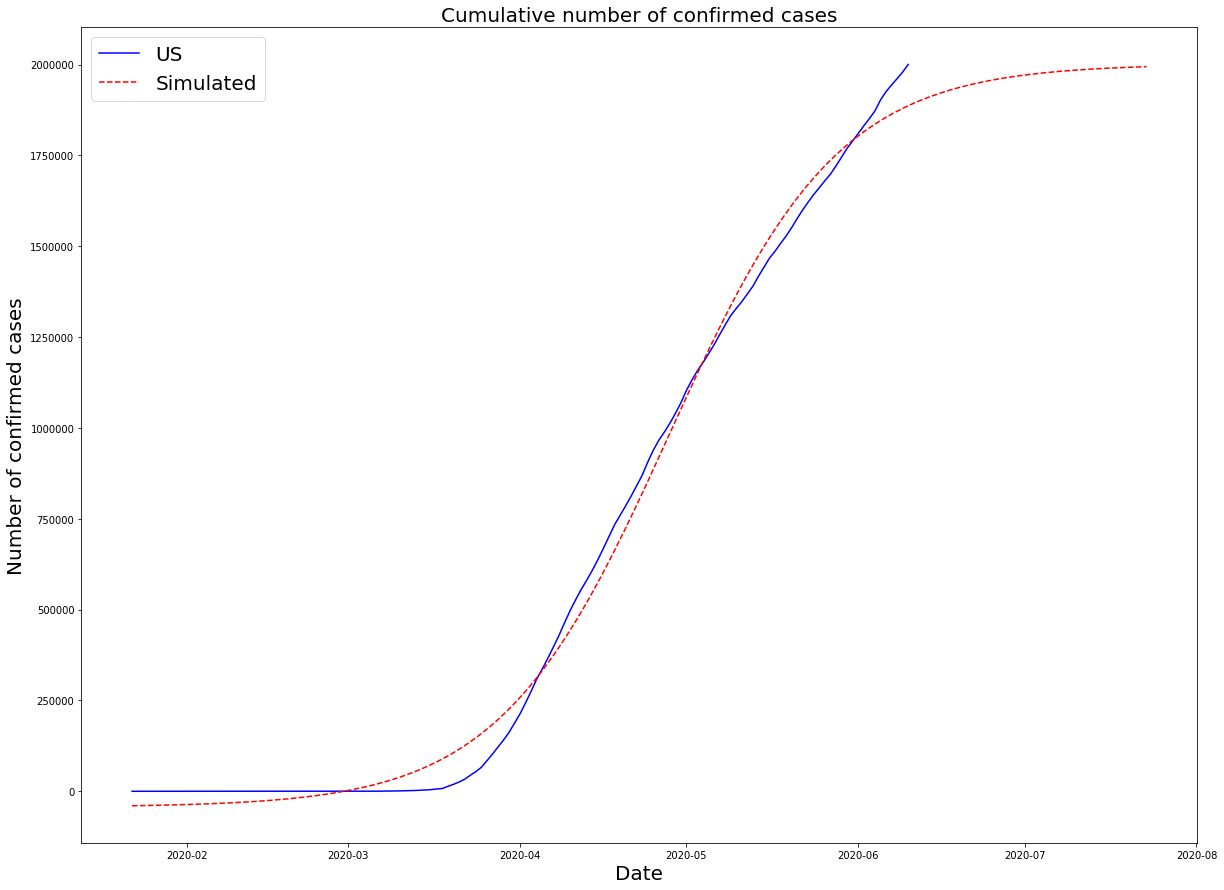

In [20]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

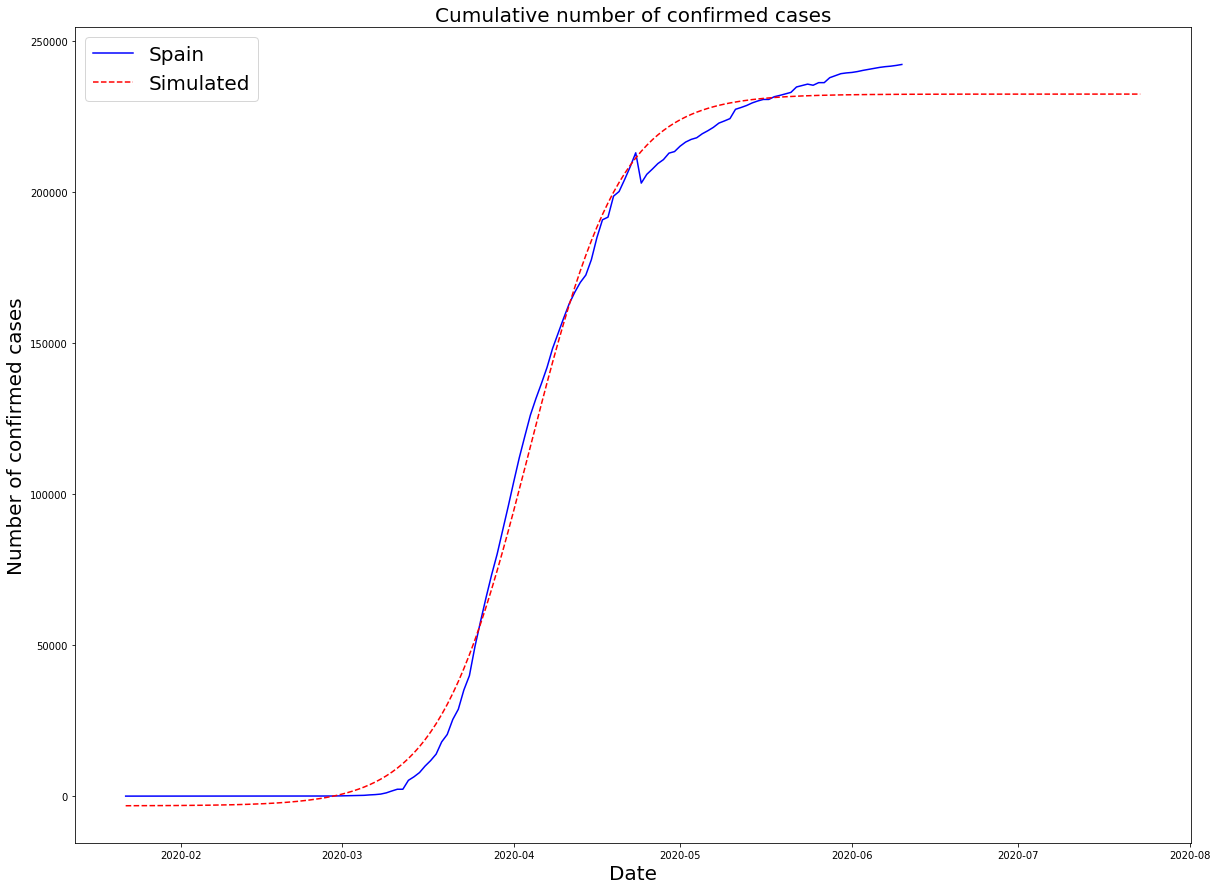

In [21]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

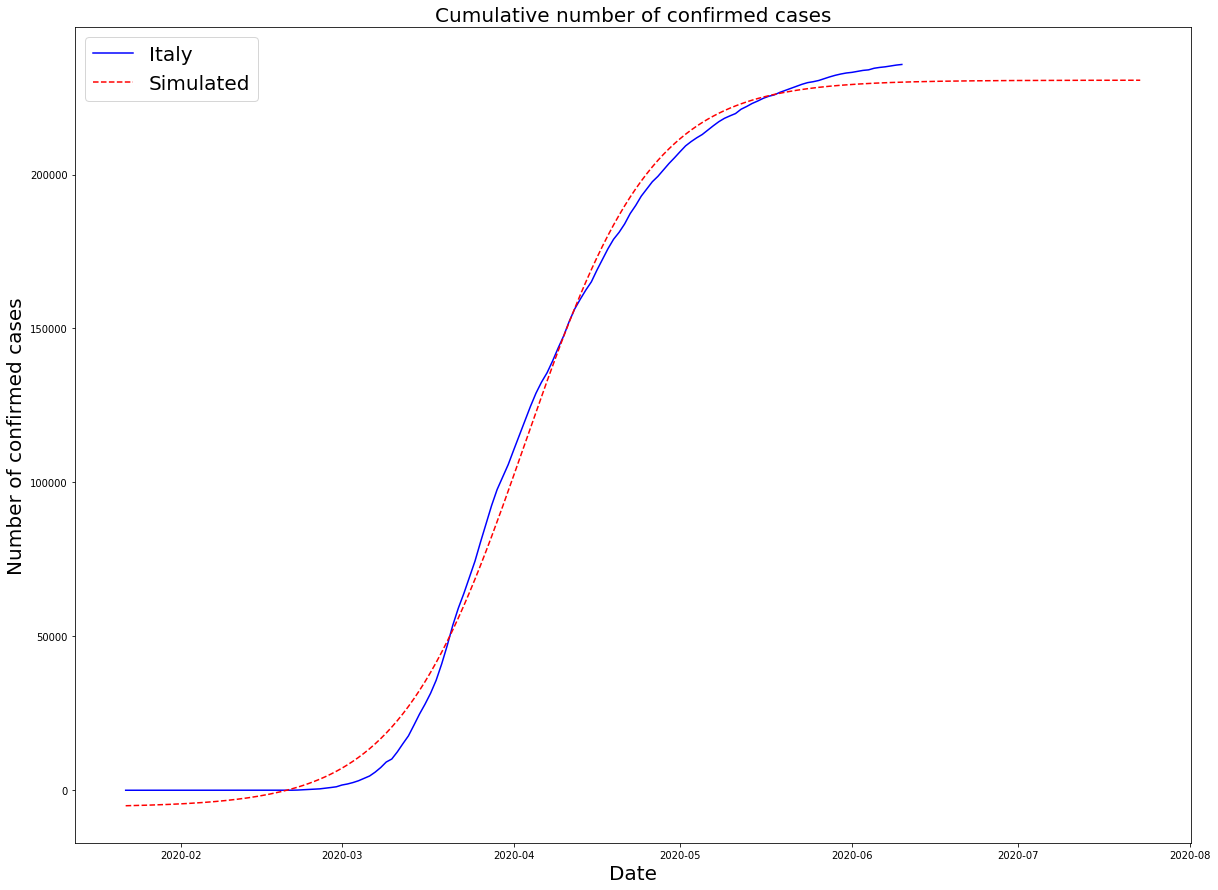

In [22]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

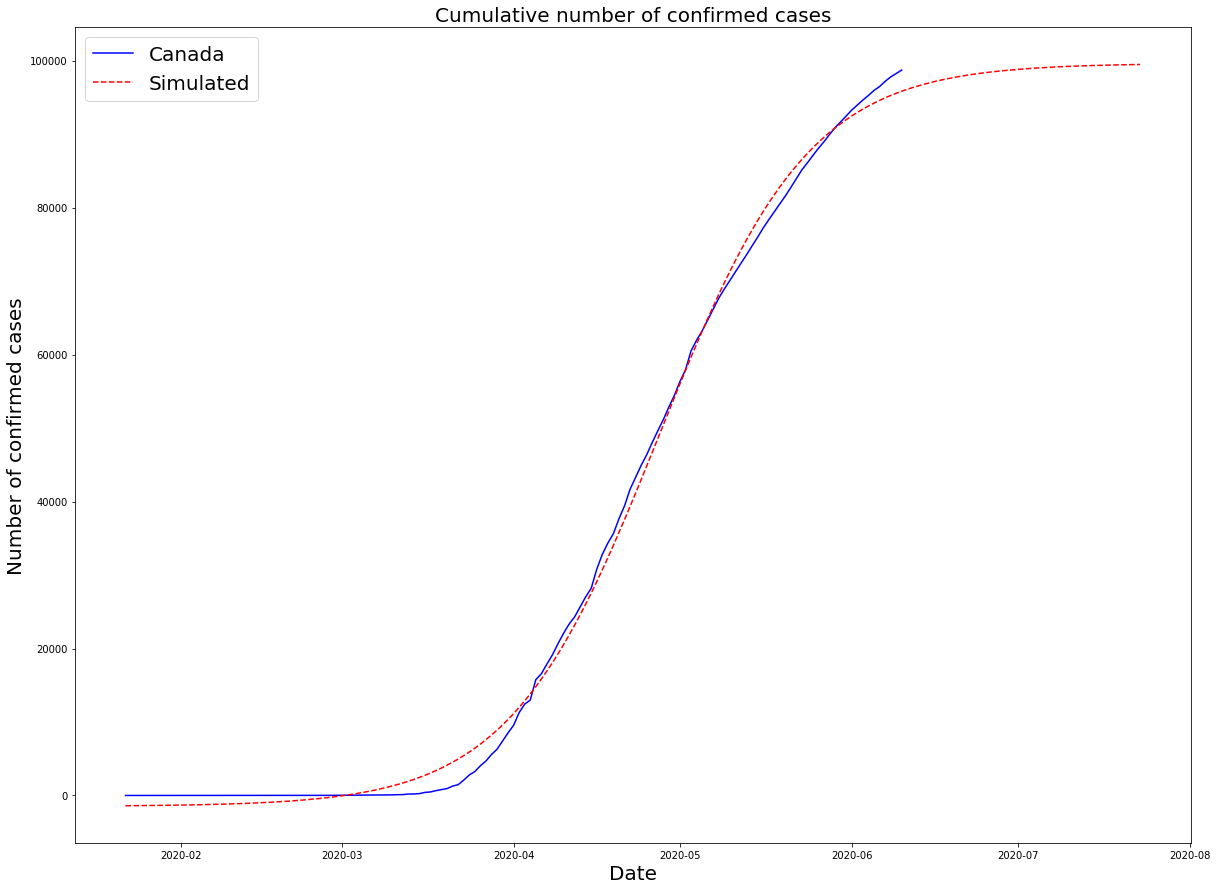

In [23]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);